<a href="https://colab.research.google.com/github/OmicsML/dance-tutorials/blob/dev/dance_tutorial_hongzhi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch_geometric==2.3.1
!pip install dgl==1.1.0 -f https://data.dgl.ai/wheels/cu117/repo.html
!pip install torchnmf==0.3.4
!pip install git+https://github.com/OmicsML/dance.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 13.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910459 sha256=c2ba198e4d05dfba2015878cebb4579cefcc6f34782862f1f833a07a3bd33a87
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch_geometric
Looking in links: https://data.dgl.ai/wheels/cu117/repo.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 MB 7.6 MB/s eta 0:00:00
  Cloning https://github.com/OmicsML/dance.git to /tmp/pip-req-build-k97pn0x2
  Running command git clone --filter=blob:none --quiet https://github.com/OmicsML/dance.git /tmp/pip-req-build-k97pn0x2
  Resolved https://github.com/OmicsML/dance.git to commit 3f24028417c726510df81ac52dc91ee10738f3f5
  Installing build dependencies ...

## Multi-modality tasks
- Example Tasks: Modality prediction, Modality Matching


### Modality Prediction

#### Task and Model Description

Modality Prediction: predicting the flow of information from DNA to RNA and RNA to Protein.
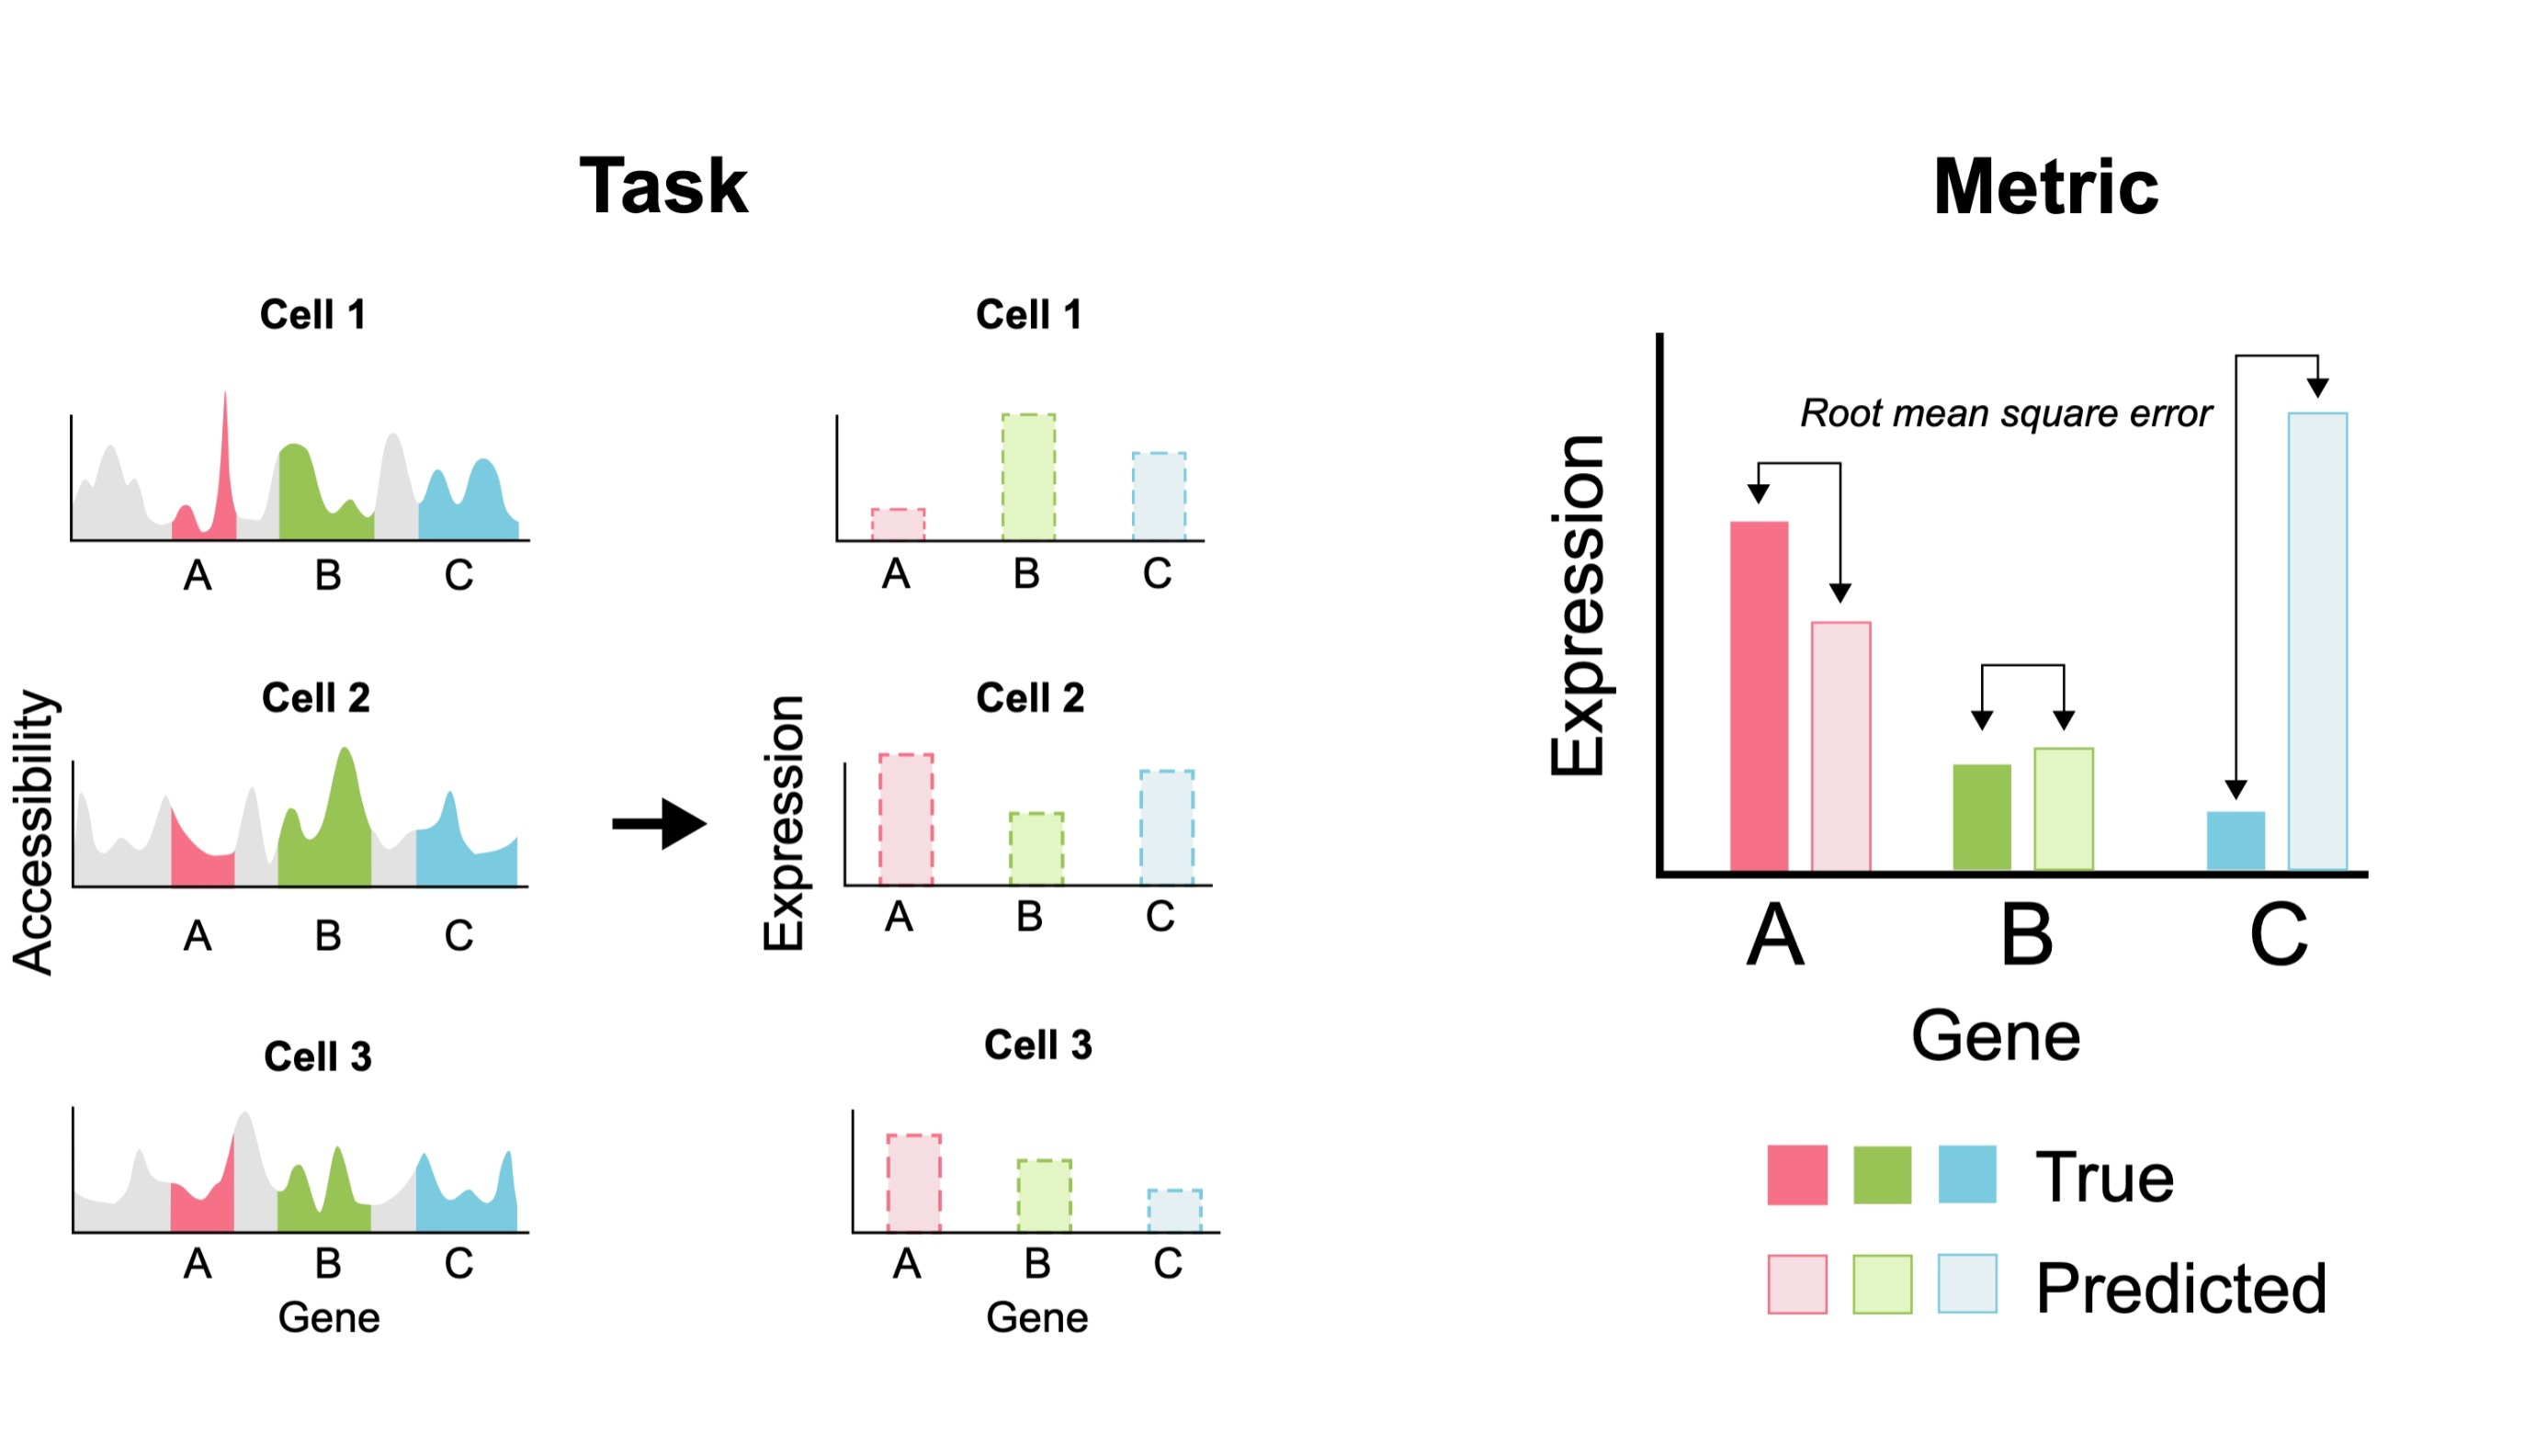

In this section, we take RNA-to-Protein as an example task, where the data are obtained from CITE-seq technology. We use BABEL[1] model as an example to demonstrate the workflow of DANCE package.
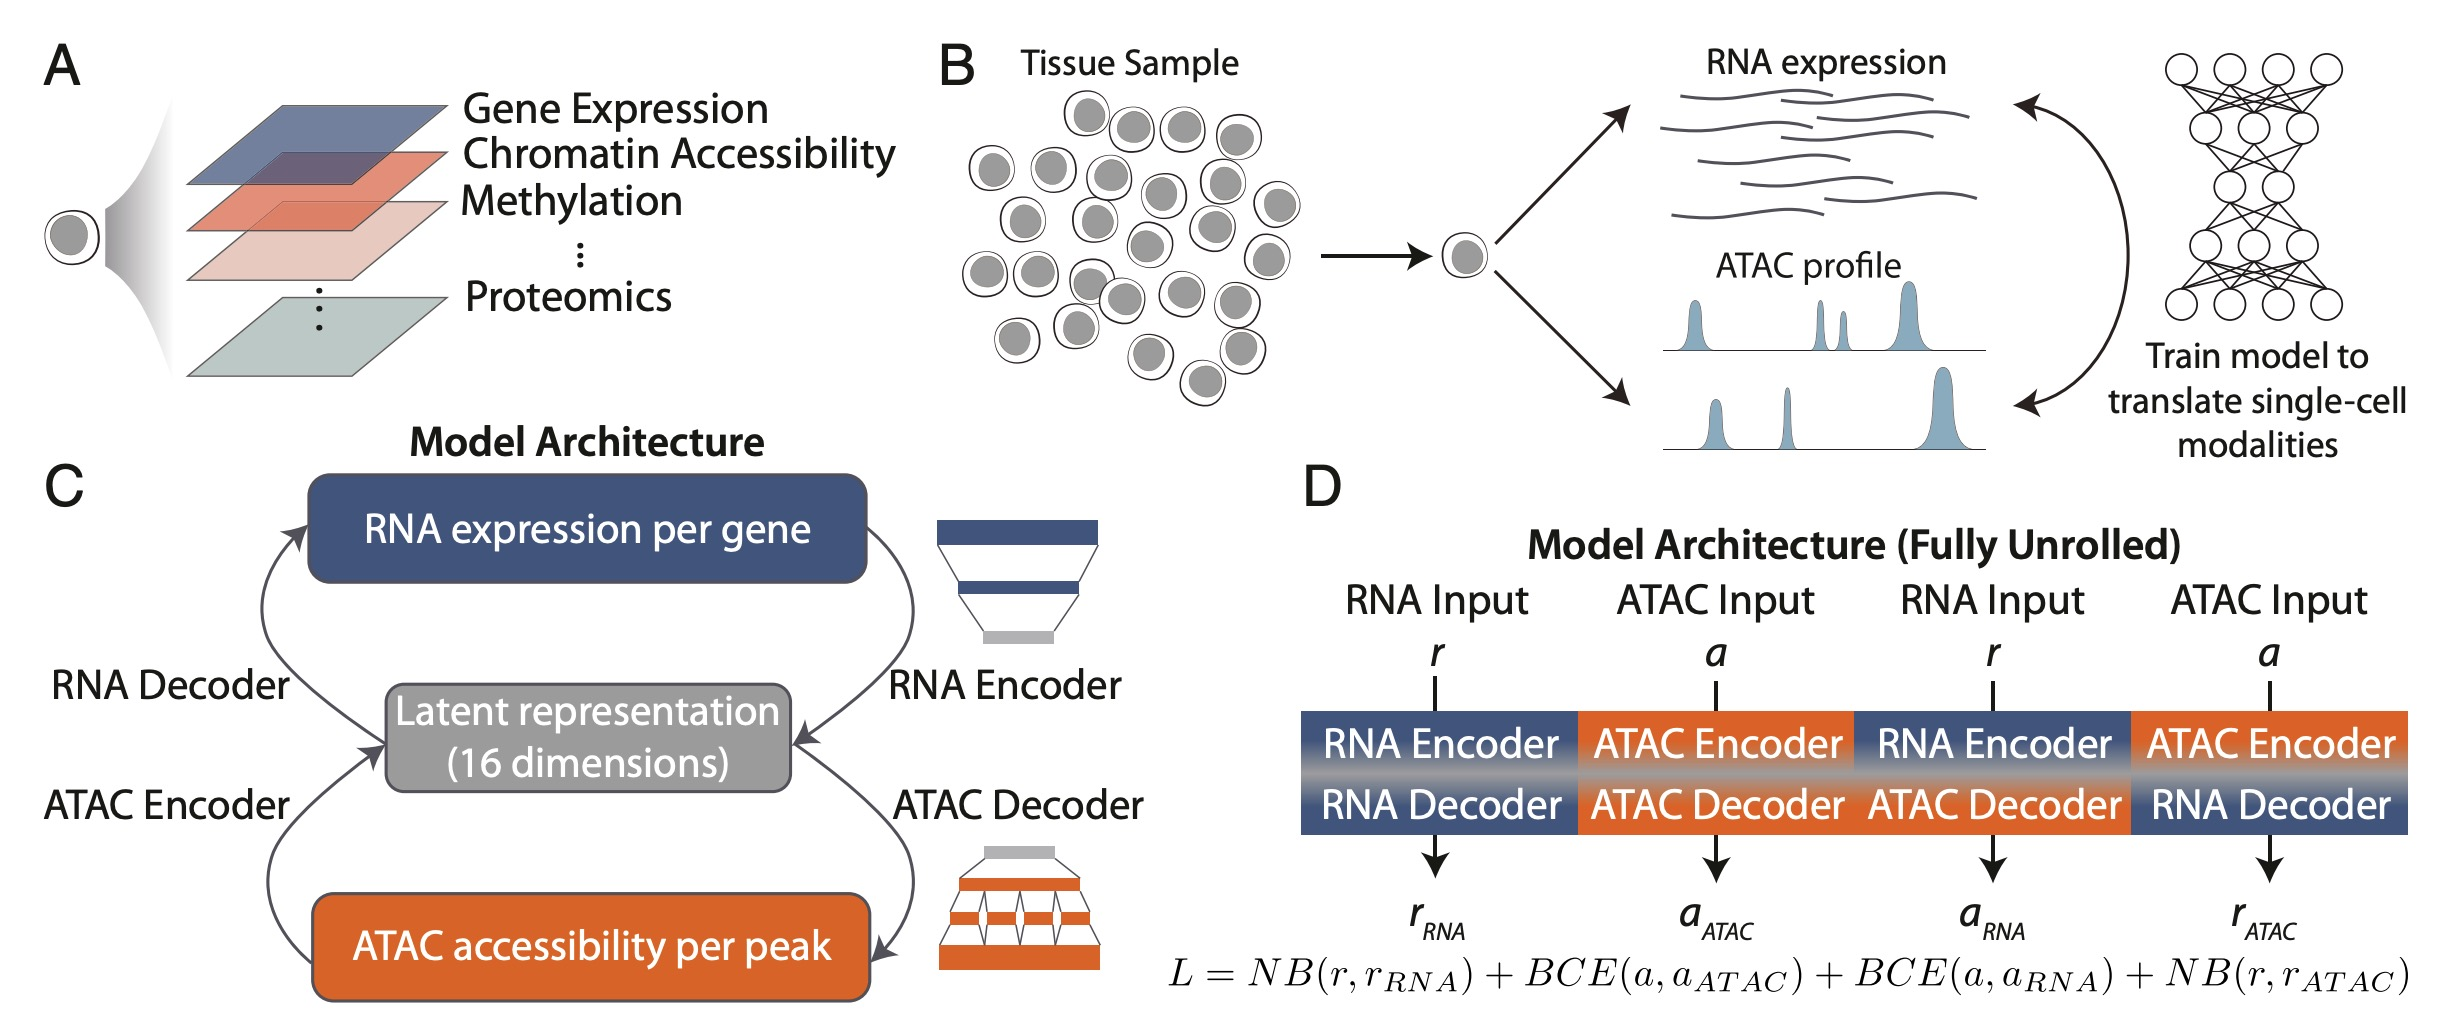

---
[1] Wu, Kevin E., et al. "BABEL enables cross-modality translation between multiomic profiles at single-cell resolution." Proceedings of the National Academy of Sciences 118.15 (2021): e2023070118.






#### Argument parsing setting

In [4]:
import anndata
import mudata
import torch
import scanpy as sc
from dance import logger
from dance.data import Data
from dance.datasets.multimodality import ModalityPredictionDataset
from dance.modules.multi_modality.predict_modality.babel import BabelWrapper
from dance.utils import set_seed
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
import argparse
import random
import torch
import os

OPTIMIZER_DICT = {
    "adam": torch.optim.Adam,
    "rmsprop": torch.optim.RMSprop,
}
rndseed = random.randint(0, 2147483647)
set_seed(rndseed)
device = 'cuda'

[INFO][2023-06-28 01:12:31,876][dance][set_seed] Setting global random seed to 795012171


#### Load data and perform necessary preprocessing

In [ ]:
dataset = ModalityPredictionDataset("openproblems_bmmc_cite_phase2_rna")
data = dataset.load_data()
data

[INFO][2023-06-26 02:32:16,988][dance][_load_raw_data] Loading /content/data/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_train_mod1.h5ad
[INFO][2023-06-26 02:32:25,272][dance][_load_raw_data] Loading /content/data/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_train_mod2.h5ad
[INFO][2023-06-26 02:32:26,039][dance][_load_raw_data] Loading /content/data/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_test_mod1.h5ad
[INFO][2023-06-26 02:32:26,285][dance][_load_raw_data] Loading /content/data/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_test_mod2.h5ad
[INFO][2023-06-26 02:32:26,315][dance][_maybe_preprocess] Preprocessing done.
/usr/local/lib/python3.10/dist-packages/mudata/_core/mudata.py:491: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(
/usr/local/lib/pyth

Data object that wraps (.data):
MuData object with n_obs × n_vars = 67175 × 14087
  uns:	'dance_config'
  2 modalities
    mod1:	67175 x 13953
      obs:	'batch', 'size_factors'
      layers:	'counts'
    mod2:	67175 x 134
      obs:	'batch', 'size_factors'
      layers:	'counts'

In [ ]:
# Construct data object
data.set_config(feature_mod="mod1", label_mod="mod2")

# Obtain training and testing data
x_train, y_train = data.get_train_data(return_type="torch")

# Colab has very limited memory (12.7GB), therefore we subsample the data
x_train = x_train[:10000]
y_train = y_train[:10000]

x_test, y_test = data.get_test_data(return_type="torch")

In [ ]:
x_test, y_test, x_test.shape, y_test.shape

(tensor([[0.0000, 0.0000, 0.0000,  ..., 0.7606, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 1.3700, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]),
 tensor([[0.2398, 0.6671, 1.3292,  ..., 0.5174, 1.2154, 0.9394],
         [0.0000, 1.2779, 1.2079,  ..., 0.3397, 0.6785, 0.8306],
         [0.0000, 0.4074, 1.5360,  ..., 0.4877, 0.9687, 0.7859],
         ...,
         [0.0579, 0.8636, 1.2542,  ..., 0.5044, 0.8885, 0.6700],
         [0.1119, 0.6962, 1.3144,  ..., 0.6354, 0.8592, 0.6036],
         [0.1033, 1.4757, 1.0849,  ..., 0.6829, 0.9257, 0.7872]]),
 torch.Size([1000, 13953]),
 torch.Size([1000, 134]))

#### Specify hyperparametsr and initialize the model

In [ ]:
parser = argparse.ArgumentParser()

######## Important hyperparameters
parser.add_argument("--subtask", default="openproblems_bmmc_cite_phase2_rna_subset")
parser.add_argument("--max_epochs", type=int, default=40)
parser.add_argument("--lr", "-l", type=float, default=0.01, help="Learning rate")
parser.add_argument("--batchsize", "-b", type=int, default=64, help="Batch size")
parser.add_argument("--hidden", type=int, default=64, help="Hidden dimensions")
parser.add_argument("--earlystop", type=int, default=2, help="Early stopping after N epochs")
parser.add_argument("--naive", "-n", action="store_true", help="Use a naive model instead of lego model")
parser.add_argument("--lossweight", type=float, default=1., help="Relative loss weight")
########

parser.add_argument("--model_folder", default="./")
parser.add_argument("--outdir", "-o", default="./", help="Directory to output to")
parser.add_argument("--resume", action="store_true")
parser.add_argument("--device", default="cuda")
parser.add_argument("--cpus", default=1, type=int)
parser.add_argument("--rnd_seed", default=rndseed, type=int)

args_defaults = parser.parse_args([])
args = argparse.Namespace(**vars(args_defaults))
args

In [ ]:
model = BabelWrapper(args, dim_in=x_train.shape[1], dim_out=y_train.shape[1])

[INFO][2023-06-26 03:01:28,331][dance][__init__] ChromDecoder with 1 output activations


#### Train and evaluate model

In [ ]:
model.fit(x_train, y_train, val_ratio=0.15)

epoch:  1
training (sum of 4 losses): 1.673737257046807
validation (prediction loss): 0.411122360459075
epoch:  2
training (sum of 4 losses): 1.3738553918393932
validation (prediction loss): 0.3740322649007854
epoch:  3
training (sum of 4 losses): 1.3292209376069837
validation (prediction loss): 0.37166829764106474
epoch:  4
training (sum of 4 losses): 1.3021443150097267
validation (prediction loss): 0.36554993123043766
epoch:  5
training (sum of 4 losses): 1.288410821355375
validation (prediction loss): 0.35949453796634684
epoch:  6
training (sum of 4 losses): 1.2724168865304244
validation (prediction loss): 0.3587612793565105
epoch:  7
training (sum of 4 losses): 1.2644911036455542
validation (prediction loss): 0.36075105207009606
epoch:  8
training (sum of 4 losses): 1.2507485052696745
validation (prediction loss): 0.35872547437228647
epoch:  9
training (sum of 4 losses): 1.2439241884346295
validation (prediction loss): 0.35870398845461504
epoch:  10
training (sum of 4 losses): 1.23

In [ ]:
model.predict(x_test)

tensor([[0.4540, 0.3182, 1.5519,  ..., 0.6725, 0.7562, 0.7575],
        [0.0000, 0.2512, 1.4982,  ..., 0.2431, 0.6391, 0.2825],
        [0.0000, 0.2953, 1.5053,  ..., 0.3185, 0.8473, 0.3942],
        ...,
        [0.0000, 0.2107, 1.1442,  ..., 0.5224, 0.6192, 0.1784],
        [0.0000, 0.1907, 1.1342,  ..., 0.1039, 0.5594, 0.2827],
        [0.2034, 0.2558, 1.5115,  ..., 0.2654, 0.6433, 0.4503]],
       device='cuda:0')

In [ ]:
model.score(x_test, y_test)

0.5041288431287377

## Modality Matching

In [2]:
from dance.datasets.multimodality import ModalityMatchingDataset
from dance.modules.multi_modality.match_modality.scmogcn import ScMoGCNWrapper
from dance.transforms.graph.cell_feature_graph import CellFeatureBipartiteGraph
import numpy as np
import torch.nn.functional as F

dataset = ModalityMatchingDataset('openproblems_bmmc_cite_phase2_rna_subset', root='./data', preprocess="pca", pkl_path='lsi_input_pca_count.pkl')
data = dataset.load_data()

# ScMoGNN graph construction
data = CellFeatureBipartiteGraph(cell_feature_channel="X_pca", mod="mod1")(data)
data = CellFeatureBipartiteGraph(cell_feature_channel="X_pca", mod="mod2")(data)
data.set_config(feature_mod=["mod1", "mod2", "mod1", "mod2"], feature_channel_type=["uns", "uns", "obs", "obs"],
                feature_channel=["g", "g", "batch", "batch"], label_mod="mod1", label_channel="labels")

data

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


[INFO][2023-06-28 01:12:02,093][dance][download_file] Downloading: /content/data/openproblems_bmmc_cite_phase2_rna_subset.zip Bytes: 34,858,859
100%|██████████| 33.2M/33.2M [00:00<00:00, 90.2MB/s]
[INFO][2023-06-28 01:12:02,488][dance][unzip_file] Unzipping /content/data/openproblems_bmmc_cite_phase2_rna_subset.zip
[INFO][2023-06-28 01:12:02,700][dance][delete_file] Deleting /content/data/openproblems_bmmc_cite_phase2_rna_subset.zip
[INFO][2023-06-28 01:12:02,707][dance][_load_raw_data] Loading /content/data/openproblems_bmmc_cite_phase2_rna_subset/openproblems_bmmc_cite_phase2_rna_subset.censor_dataset.output_train_mod1.h5ad
[INFO][2023-06-28 01:12:03,095][dance][_load_raw_data] Loading /content/data/openproblems_bmmc_cite_phase2_rna_subset/openproblems_bmmc_cite_phase2_rna_subset.censor_dataset.output_train_mod2.h5ad
[INFO][2023-06-28 01:12:03,225][dance][_load_raw_data] Loading /content/data/openproblems_bmmc_cite_phase2_rna_subset/openproblems_bmmc_cite_phase2_rna_subset.censor_dat

Data object that wraps (.data):
MuData object with n_obs × n_vars = 9000 × 4134
  uns:	'dance_config'
  2 modalities
    mod1:	9000 x 4000
      obs:	'batch', 'size_factors'
      uns:	'g'
      obsm:	'X_pca', 'labels'
      layers:	'counts'
    mod2:	9000 x 134
      obs:	'batch'
      uns:	'g'
      obsm:	'X_pca'
      layers:	'counts'

In [5]:
(g_mod1, g_mod2, batch_mod1, batch_mod2), z = data.get_data(return_type="default")
train_size = len(data.get_split_idx("train"))
test_idx = np.arange(train_size, g_mod1.num_nodes("cell"))
z_test = F.one_hot(torch.from_numpy(z[train_size:]).long())
labels1 = torch.argmax(z_test, dim=0).to(device)
labels2 = torch.argmax(z_test, dim=1).to(device)
g_mod1 = g_mod1.to(device)
g_mod2 = g_mod2.to(device)

In [13]:
parser = argparse.ArgumentParser()
parser.add_argument("--layers", default=4, type=int, choices=[3, 4, 5, 6, 7])
parser.add_argument("--learning_rate", default=6e-4, type=float)
parser.add_argument("--disable_propagation", default=0, type=int, choices=[0, 1, 2])
parser.add_argument("--auxiliary_loss", default=True, type=bool)
parser.add_argument("--epochs", default=2000, type=int)
parser.add_argument("--hidden_size", default=64, type=int)
parser.add_argument("--temperature", default=2.739896, type=float)
parser.add_argument("--device", default='cuda', type=str)
parser.add_argument("--rnd_seed", default=rndseed, type=int)

args_defaults = parser.parse_args([])
args = argparse.Namespace(**vars(args_defaults))
data_folder = './data/'
device = 'cuda'
args

Namespace(layers=4, learning_rate=0.0006, disable_propagation=0, auxiliary_loss=True, epochs=2000, hidden_size=64, temperature=2.739896, device='cuda', rnd_seed=795012171)

In [14]:
model = ScMoGCNWrapper(
    args,
    [
        [(g_mod1.num_nodes("feature"), 512, 0.25), (512, 512, 0.25), (512, args.hidden_size)],
        [(g_mod2.num_nodes("feature"), 512, 0.2), (512, 512, 0.2), (512, args.hidden_size)],
        [(args.hidden_size, 512, 0.2), (512, g_mod1.num_nodes("feature"))],
        [(args.hidden_size, 512, 0.2), (512, g_mod2.num_nodes("feature"))],
    ],
    args.temperature,
)

In [15]:
model.fit(g_mod1, g_mod2, labels1, labels2, train_size=train_size)

[INFO][2023-06-28 01:15:05,146][dance][fit] epoch 0
[INFO][2023-06-28 01:15:05,209][dance][fit] training loss: 18.51451, forward: 0.0003, backward: 0.0008
[INFO][2023-06-28 01:15:05,230][dance][fit] validation score: 0.00113
[INFO][2023-06-28 01:15:05,250][dance][fit] epoch 1
[INFO][2023-06-28 01:15:05,303][dance][fit] training loss: 16.28842, forward: 0.0013, backward: 0.0008
[INFO][2023-06-28 01:15:05,330][dance][fit] validation score: 0.00175
[INFO][2023-06-28 01:15:05,350][dance][fit] epoch 2
[INFO][2023-06-28 01:15:05,406][dance][fit] training loss: 15.56802, forward: 0.0010, backward: 0.0005
[INFO][2023-06-28 01:15:05,421][dance][fit] validation score: 0.00188
[INFO][2023-06-28 01:15:05,441][dance][fit] epoch 3
[INFO][2023-06-28 01:15:05,491][dance][fit] training loss: 14.90948, forward: 0.0018, backward: 0.0023
[INFO][2023-06-28 01:15:05,511][dance][fit] validation score: 0.00238
[INFO][2023-06-28 01:15:05,530][dance][fit] epoch 4
[INFO][2023-06-28 01:15:05,581][dance][fit] trai

In [16]:
model.predict(test_idx, enhance=True, batch1=batch_mod1, batch2=batch_mod2)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [17]:
model.score(test_idx, labels_matrix=z_test, enhance=True, batch1=batch_mod1, batch2=batch_mod2)

0.146